<a href="https://colab.research.google.com/github/Ralo93/Hands-On-Large-Language-Models/blob/main/Kopie_von_Chapter_5_Text_Clustering_and_Topic_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### [OPTIONAL] - Installing Packages on <img src="https://colab.google/static/images/icons/colab.png" width=100>

If you are viewing this notebook on Google Colab (or any other cloud vendor), you need to **uncomment and run** the following codeblock to install the dependencies for this chapter:

---

💡 **NOTE**: We will want to use a GPU to run the examples in this notebook. In Google Colab, go to
**Runtime > Change runtime type > Hardware accelerator > GPU > GPU type > T4**.

---


In [1]:
# %%capture
# !pip install bertopic datasets openai datamapplot

# **ArXiv Articles: Computation and Language**

In [ ]:
# Load data from huggingface
from datasets import load_dataset
dataset = load_dataset("maartengr/arxiv_nlp")["train"]

# Extract metadata
abstracts = dataset["Abstracts"]
titles = dataset["Titles"]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


# **A Common Pipeline for Text Clustering**

## **1. Embedding Documents**

In [ ]:
from sentence_transformers import SentenceTransformer

# Create an embedding for each abstract
embedding_model = SentenceTransformer('thenlper/gte-small')
embeddings = embedding_model.encode(abstracts, show_progress_bar=True)

Batches:   0%|          | 0/1405 [00:00<?, ?it/s]

In [ ]:
# Check the dimensions of the resulting embeddings
embeddings.shape

(44949, 384)

## **2. Reducing the Dimensionality of Embeddings**

In [ ]:
from umap import UMAP

# We reduce the input embeddings from 384 dimenions to 5 dimenions
umap_model = UMAP(
    n_components=5, min_dist=0.0, metric='cosine', random_state=42
)
reduced_embeddings = umap_model.fit_transform(embeddings)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


## **3. Cluster the Reduced Embeddings**

In [ ]:
from hdbscan import HDBSCAN

# We fit the model and extract the clusters
hdbscan_model = HDBSCAN(
    min_cluster_size=50, metric='euclidean', cluster_selection_method='eom'
).fit(reduced_embeddings)
clusters = hdbscan_model.labels_

# How many clusters did we generate?
len(set(clusters))

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


156

## **Inspecting the Clusters**

Manually inspect the first three documents in cluster 0:

In [ ]:
import numpy as np

# Print first three documents in cluster 0
cluster = 0
for index in np.where(clusters==cluster)[0][:3]:
    print(abstracts[index][:300] + "... \n")

  This works aims to design a statistical machine translation from English text
to American Sign Language (ASL). The system is based on Moses tool with some
modifications and the results are synthesized through a 3D avatar for
interpretation. First, we translate the input text to gloss, a written fo... 

  Researches on signed languages still strongly dissociate lin- guistic issues
related on phonological and phonetic aspects, and gesture studies for
recognition and synthesis purposes. This paper focuses on the imbrication of
motion and meaning for the analysis, synthesis and evaluation of sign lang... 

  Modern computational linguistic software cannot produce important aspects of
sign language translation. Using some researches we deduce that the majority of
automatic sign language translation systems ignore many aspects when they
generate animation; therefore the interpretation lost the truth inf... 



Next, we reduce our embeddings to 2-dimensions so that we can plot them and get a rough understanding of the generated clusters.

In [ ]:
import pandas as pd

# Reduce 384-dimensional embeddings to 2 dimensions for easier visualization
reduced_embeddings = UMAP(
    n_components=2, min_dist=0.0, metric='cosine', random_state=42
).fit_transform(embeddings)

# Create dataframe
df = pd.DataFrame(reduced_embeddings, columns=["x", "y"])
df["title"] = titles
df["cluster"] = [str(c) for c in clusters]

# Select outliers and non-outliers (clusters)
clusters_df = df.loc[df.cluster != "-1", :]
outliers_df = df.loc[df.cluster == "-1", :]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


### Static Plot

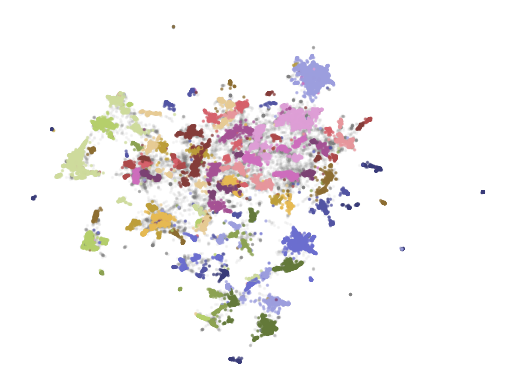

In [ ]:
import matplotlib.pyplot as plt

# Plot outliers and non-outliers seperately
plt.scatter(outliers_df.x, outliers_df.y, alpha=0.05, s=2, c="grey")
plt.scatter(
    clusters_df.x, clusters_df.y, c=clusters_df.cluster.astype(int),
    alpha=0.6, s=2, cmap='tab20b'
)
plt.axis('off')
# plt.savefig("matplotlib.png", dpi=300)  # Uncomment to save the graph as a .png

# From Text Clustering to Topic Modeling

## **BERTopic: A Modular Topic Modeling Framework**

In [ ]:
from bertopic import BERTopic

# Train our model with our previously defined models
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    verbose=True
).fit(abstracts, embeddings)

2024-04-24 10:38:31,273 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-04-24 10:39:22,540 - BERTopic - Dimensionality - Completed ✓
2024-04-24 10:39:22,543 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-04-24 10:39:24,548 - BERTopic - Cluster - Completed ✓
2024-04-24 10:39:24,563 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-04-24 10:39:34,185 - BERTopic - Representation - Completed ✓


Now, let's start exploring the topics that we got by running the code above.

In [ ]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,14520,-1_the_of_and_to,"[the, of, and, to, in, we, that, language, for...",[ This paper presents new state-of-the-art mo...
1,0,2290,0_speech_asr_recognition_end,"[speech, asr, recognition, end, acoustic, spea...",[ End-to-end models have achieved impressive ...
2,1,1403,1_medical_clinical_biomedical_patient,"[medical, clinical, biomedical, patient, healt...",[ Recent years have seen particular interest ...
3,2,1156,2_sentiment_aspect_analysis_reviews,"[sentiment, aspect, analysis, reviews, opinion...",[ Aspect-based sentiment analysis of review t...
4,3,986,3_translation_nmt_machine_neural,"[translation, nmt, machine, neural, bleu, engl...",[ Neural machine translation (NMT) becomes a ...
...,...,...,...,...,...
151,150,54,150_coherence_discourse_paragraph_text,"[coherence, discourse, paragraph, text, cohesi...",[ While there has been significant progress t...
152,151,54,151_prompt_prompts_optimization_prompting,"[prompt, prompts, optimization, prompting, llm...",[ Prompt optimization aims to find the best p...
153,152,53,152_sentence_sts_embeddings_similarity,"[sentence, sts, embeddings, similarity, embedd...",[ Sentence representation at the semantic lev...
154,153,53,153_counseling_mental_health_therapy,"[counseling, mental, health, therapy, psychoth...",[ Mental health care poses an increasingly se...


Hundreds of topics were generated using the default model! To get the top 10 keywords per topic as well as their c-TF-IDF weights, we can use the `get_topic()` function:

In [ ]:
topic_model.get_topic(0)

[('speech', 0.028177697715245358),
 ('asr', 0.018971184497453525),
 ('recognition', 0.013457745472471012),
 ('end', 0.00980445092749381),
 ('acoustic', 0.009452082794507863),
 ('speaker', 0.0068822647060204885),
 ('audio', 0.006807649923681604),
 ('the', 0.0063343444687017645),
 ('error', 0.006320144717019838),
 ('automatic', 0.006290216996043161)]

We can use the `find_topics()` function to search for specific topics based on a search term. Let’s search for a topic about topic modeling:

In [ ]:
topic_model.find_topics("topic modeling")

([22, -1, 1, 47, 32],
 [0.95456535, 0.91173744, 0.9074769, 0.9067007, 0.90510106])

It returns that topic 22 has a relatively high similarity (0.95) with our search term. If we then inspect the topic, we can see that it is indeed a topic about topic modeling:

In [ ]:
topic_model.get_topic(22)

[('topic', 0.06634619076655907),
 ('topics', 0.035308535091932707),
 ('lda', 0.016386314730705634),
 ('latent', 0.013372311924864435),
 ('document', 0.012973600191120576),
 ('documents', 0.012383715497143821),
 ('modeling', 0.011978375291037142),
 ('dirichlet', 0.010078277589545706),
 ('word', 0.008505619415413312),
 ('allocation', 0.007930890698168108)]

That seems like a topic that is, in part, characterized by the classic LDA technique. Let's see if the BERTopic paper was also assigned to topic 22:

In [ ]:
topic_model.topics_[titles.index('BERTopic: Neural topic modeling with a class-based TF-IDF procedure')]

22

It is! We expected it might be because there are non-LDA specific words in the topic describtion such as "clustering" and "topic".

### **Visualizations**

**Visualize Documents**

In [ ]:
# Visualize topics and documents
fig = topic_model.visualize_documents(
    titles,
    reduced_embeddings=reduced_embeddings,
    width=1200,
    hide_annotations=True
)

# Update fonts of legend for easier visualization
fig.update_layout(font=dict(size=16))

In [ ]:
# Visualize barchart with ranked keywords
topic_model.visualize_barchart()

# Visualize relationships between topics
topic_model.visualize_heatmap(n_clusters=30)

# Visualize the potential hierarchical structure of topics
topic_model.visualize_hierarchy()

## **Representation Models**

In these examples that follow, we will update our topic representations **after** having trained our model. This allows for quick iteration. If, however, you want to use a representation model at the start of training, you will need to run it as follows:

```python
from bertopic.representation import KeyBERTInspired
from bertopic import BERTopic

# Create your representation model
representation_model = KeyBERTInspired()

# Use the representation model in BERTopic on top of the default pipeline
topic_model = BERTopic(representation_model=representation_model)
```

To use the representation models, we are first going to duplicate our topic model such that easily show the differences between a model with and without representation model.

In [ ]:
# Save original representations
from copy import deepcopy
original_topics = deepcopy(topic_model.topic_representations_)

In [ ]:
def topic_differences(model, original_topics, nr_topics=5):
    """Show the differences in topic representations between two models """
    df = pd.DataFrame(columns=["Topic", "Original", "Updated"])
    for topic in range(nr_topics):

        # Extract top 5 words per topic per model
        og_words = " | ".join(list(zip(*original_topics[topic]))[0][:5])
        new_words = " | ".join(list(zip(*model.get_topic(topic)))[0][:5])
        df.loc[len(df)] = [topic, og_words, new_words]

    return df

### KeyBERTInspired

In [ ]:
from bertopic.representation import KeyBERTInspired

# Update our topic representations using KeyBERTInspired
representation_model = KeyBERTInspired()
topic_model.update_topics(abstracts, representation_model=representation_model)

# Show topic differences
topic_differences(topic_model, original_topics)

,Topic,Original,Updated
0,0,speech | asr | recognition | end | acoustic,speech | encoder | phonetic | language | trans...
1,1,medical | clinical | biomedical | patient | he...,nlp | ehr | clinical | biomedical | language
2,2,sentiment | aspect | analysis | reviews | opinion,aspect | sentiment | aspects | sentiments | cl...
3,3,translation | nmt | machine | neural | bleu,translation | translating | translate | transl...
4,4,summarization | summaries | summary | abstract...,summarization | summarizers | summaries | summ...


### Maximal Marginal Relevance

In [ ]:
from bertopic.representation import MaximalMarginalRelevance

# Update our topic representations to MaximalMarginalRelevance
representation_model = MaximalMarginalRelevance(diversity=0.5)
topic_model.update_topics(abstracts, representation_model=representation_model)

# Show topic differences
topic_differences(topic_model, original_topics)

,Topic,Original,Updated
0,0,speech | asr | recognition | end | acoustic,speech | asr | error | model | training
1,1,medical | clinical | biomedical | patient | he...,clinical | biomedical | patient | healthcare |...
2,2,sentiment | aspect | analysis | reviews | opinion,sentiment | analysis | reviews | absa | polarity
3,3,translation | nmt | machine | neural | bleu,translation | nmt | bleu | parallel | multilin...
4,4,summarization | summaries | summary | abstract...,summarization | document | extractive | rouge ...


## Text Generation



### Flan-T5

In [ ]:
from transformers import pipeline
from bertopic.representation import TextGeneration

prompt = """I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the documents and keywords, what is this topic about?"""

# Update our topic representations using Flan-T5
generator = pipeline('text2text-generation', model='google/flan-t5-small')
representation_model = TextGeneration(
    generator, prompt=prompt, doc_length=50, tokenizer="whitespace"
)
topic_model.update_topics(abstracts, representation_model=representation_model)

# Show topic differences
topic_differences(topic_model, original_topics)

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

100%|██████████| 156/156 [01:28<00:00,  1.76it/s]


,Topic,Original,Updated
0,0,speech | asr | recognition | end | acoustic,Speech-to-description | | | |
1,1,medical | clinical | biomedical | patient | he...,Science/Tech | | | |
2,2,sentiment | aspect | analysis | reviews | opinion,Review | | | |
3,3,translation | nmt | machine | neural | bleu,Attention-based neural machine translation | ...
4,4,summarization | summaries | summary | abstract...,Summarization | | | |


### OpenAI

In [ ]:
import openai
from bertopic.representation import OpenAI

prompt = """
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: [KEYWORDS]

Based on the information above, extract a short topic label in the following format:
topic: <short topic label>
"""

# Update our topic representations using GPT-3.5
client = openai.OpenAI(api_key="YOUR_KEY_HERE")
representation_model = OpenAI(
    client, model="gpt-3.5-turbo", exponential_backoff=True, chat=True, prompt=prompt
)
topic_model.update_topics(abstracts, representation_model=representation_model)

# Show topic differences
topic_differences(topic_model, original_topics)

100%|██████████| 156/156 [02:13<00:00,  1.17it/s]


,Topic,Original,Updated
0,0,speech | asr | recognition | end | acoustic,Leveraging External Data for Improving Low-Res...
1,1,medical | clinical | biomedical | patient | he...,Improved Representation Learning for Biomedica...
2,2,sentiment | aspect | analysis | reviews | opinion,"""Advancements in Aspect-Based Sentiment Analys..."
3,3,translation | nmt | machine | neural | bleu,Neural Machine Translation Enhancements
4,4,summarization | summaries | summary | abstract...,Document Summarization Techniques


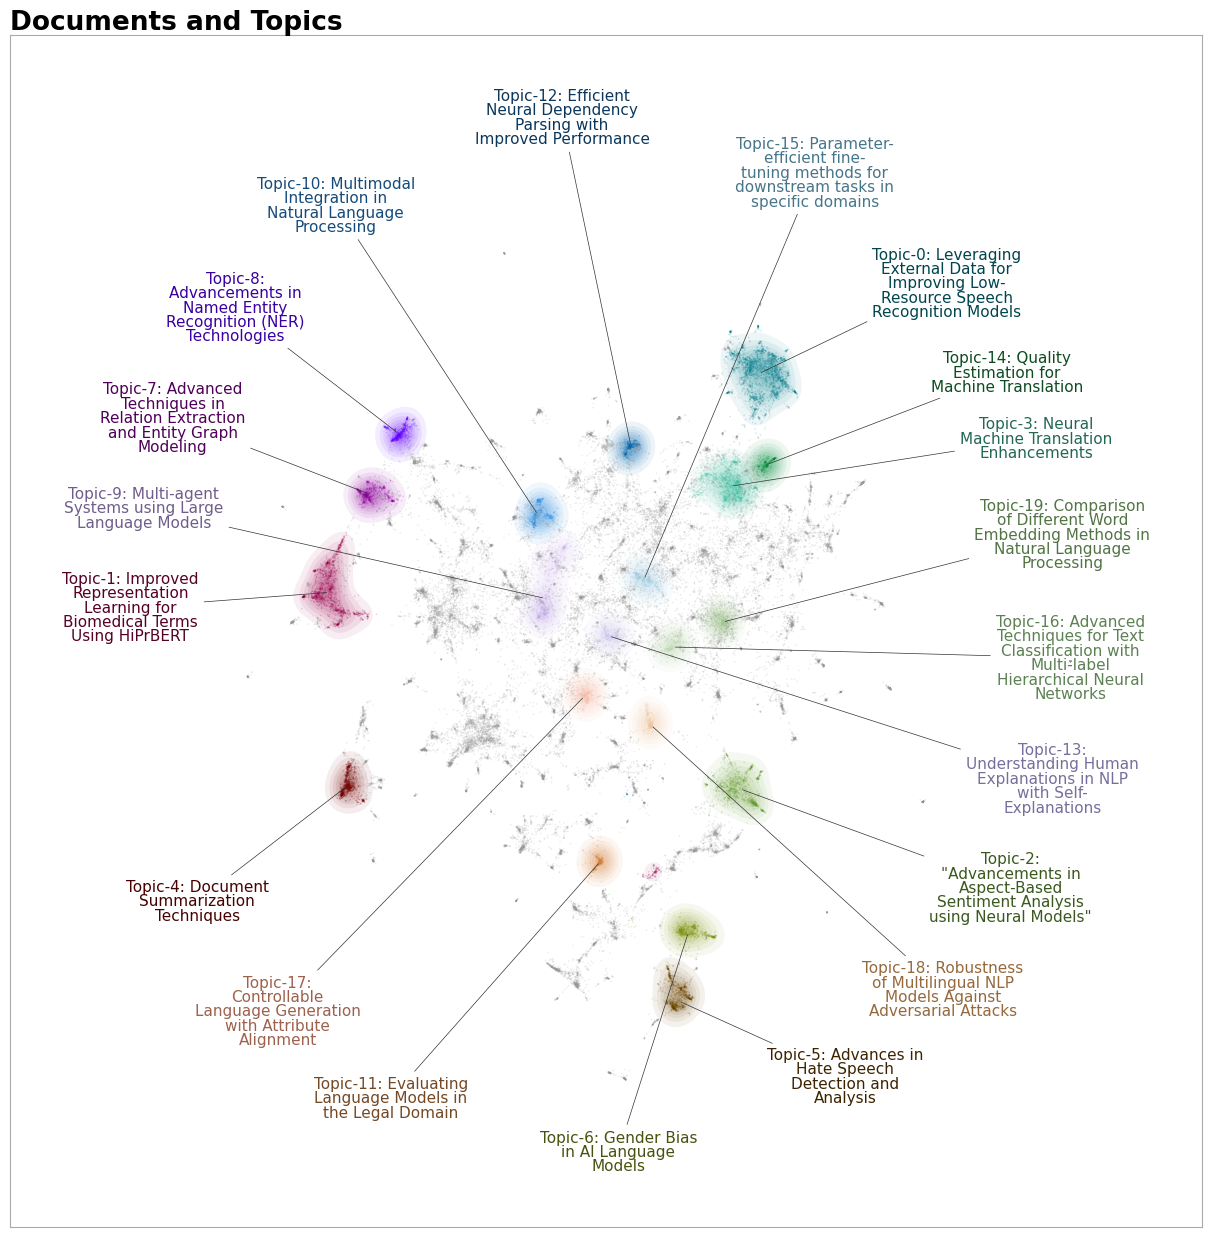

In [ ]:
# Visualize topics and documents
fig = topic_model.visualize_document_datamap(
    titles,
    topics=list(range(20)),
    reduced_embeddings=reduced_embeddings,
    width=1200,
    label_font_size=11,
    label_wrap_width=20,
    use_medoids=True,
)
plt.savefig("datamapplot.png", dpi=300)


## **BONUS**: Word Cloud

Make sure to pip install `wordcloud` first in order to follow this bonus:


First, we need to make sure that each topic is described by a bit more words than just 10 as that would make for a much more interesting wordcloud.

In [ ]:
topic_model.update_topics(abstracts, top_n_words=500)

Then, we can run the following code to generate the wordcloud for our topic modeling topic:

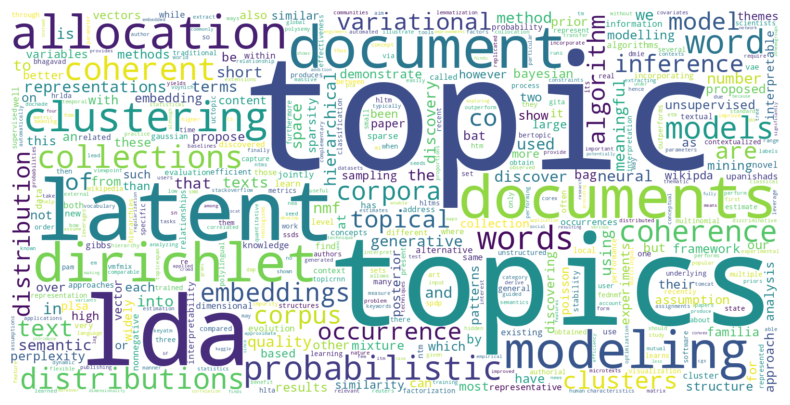

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    plt.figure(figsize=(10,5))
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000, width=1600, height=800)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Show wordcloud
create_wordcloud(topic_model, topic=17)

# Task
upload this as dataset instead of the maartenger arsiv and stuff. change the colabs second cell

Here is all the data you need:
"legislaturperiode_20.csv"

## Data loading

### Subtask:
Load the dataset "legislaturperiode_20.csv" into a pandas DataFrame.


**Reasoning**:
Load the dataset "legislaturperiode_20.csv" into a pandas DataFrame and display the first few rows.



## Data exploration

### Subtask:
Explore the loaded dataset to understand its structure, identify missing values, and examine the data types of each column.


In [5]:
!pip install plotly

In [2]:
import pandas as pd

try:
    df = pd.read_csv('legislaturperiode_20.csv')
    display(df.head())
except FileNotFoundError:
    print("Error: 'legislaturperiode_20.csv' not found.")
    df = None
except pd.errors.ParserError:
    print("Error: Could not parse the CSV file.")
    df = None
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    df = None

,Unnamed: 0,speech_content,politician_name,electoral_term,position_short,position_long,date,faction
0,0,Sehr geehrter Herr Alterspräsident! So muss ...,Gabriele Katzmarek,20,MdB,MdB,2021-10-26,SPD
1,1,Herr Präsident! Liebe Kolleginnen und Kolleg...,Stefan Müller,20,MdB,MdB,2021-10-26,CDU/CSU
2,2,Sehr geehrter Herr Alterspräsident Wolfgang ...,Britta Haßelmann,20,MdB,MdB,2021-10-26,Bündnis 90/Die Grünen
3,3,Sehr geehrter Herr Präsident! Meine lieben K...,Marco Buschmann,20,MdB,MdB,2021-10-26,FDP
4,4,Herr Alterspräsident! Lassen Sie mich zunäch...,Stephan Brandner,20,MdB,MdB,2021-10-26,AfD


**Reasoning**:
I need to explore the dataset to understand its structure, identify missing values, and examine the data types of each column. This involves checking the shape, using .info(), .describe(), and .value_counts(), and summarizing observations.



In [2]:
# Check the shape of the DataFrame
print("Shape of the DataFrame:", df.shape)

# Get a concise summary of the DataFrame
df.info()

# Generate descriptive statistics for numerical columns
print("\nDescriptive statistics for numerical columns:")
display(df.describe())

# Explore unique values and frequencies for categorical columns
categorical_cols = ['politician_name', 'electoral_term', 'position_short', 'position_long', 'date', 'faction']
for col in categorical_cols:
    print(f"\nUnique values and frequencies for '{col}':")
    display(df[col].value_counts())

# Identify potential issues and inconsistencies
print("\nPotential Issues and Inconsistencies:")
missing_values = df.isnull().sum()
missing_cols = missing_values[missing_values > 0]
if not missing_cols.empty:
    print("Columns with missing values:")
    display(missing_cols)
else:
    print("No missing values found.")

print("\nData Types:")
print(df.dtypes)

Shape of the DataFrame: (27125, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27125 entries, 0 to 27124
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       27125 non-null  int64 
 1   speech_content   27125 non-null  object
 2   politician_name  27125 non-null  object
 3   electoral_term   27125 non-null  int64 
 4   position_short   27125 non-null  object
 5   position_long    27125 non-null  object
 6   date             27125 non-null  object
 7   faction          27124 non-null  object
dtypes: int64(2), object(6)
memory usage: 1.7+ MB

Descriptive statistics for numerical columns:


,Unnamed: 0,electoral_term
count,27125.000000,27125.0
mean,13562.000000,20.0
std,7830.457362,0.0
min,0.000000,20.0
25%,6781.000000,20.0
50%,13562.000000,20.0
75%,20343.000000,20.0
max,27124.000000,20.0



Unique values and frequencies for 'politician_name':


,count
politician_name,
Olaf Scholz,375
Robert Habeck,231
Nancy Faeser,227
Karl Lauterbach,222
Christian Lindner,209
...,...
Peter Ramsauer,1
Volker Münz,1
Jürgen Dusel,1



Unique values and frequencies for 'electoral_term':


,count
electoral_term,
20,27125



Unique values and frequencies for 'position_short':


,count
position_short,
MdB,23400
Minister,2912
Bundeskanzler,368
Außenministerin,211
Gast,82
Ehemaliger Bundestagsabgeordneter,62
Not found,57
Bundestagsvizepräsident,14
Guest,7



Unique values and frequencies for 'position_long':


,count
position_long,
MdB,23457
Bundeskanzler,368
Bundesminister für Wirtschaft und Klimaschutz,229
Bundesministerin des Innern und für Heimat,227
Bundesminister für Gesundheit,212
...,...
Ministerin (Baden-Württemberg),1
Ministerpräsident (Hessen),1
Ministerpräsident (Rheinland-Pfalz),1



Unique values and frequencies for 'date':


,count
date,
2023-09-21,227
2024-02-22,219
2024-10-17,215
2024-03-21,210
2024-12-19,209
...,...
2024-11-15,21
2023-11-27,20
2021-12-15,19



Unique values and frequencies for 'faction':


,count
faction,
SPD,6789
CDU/CSU,6216
Bündnis 90/Die Grünen,4675
FDP,3679
AfD,3442
DIE LINKE.,1950
BSW,162
SSW,92
Fraktionslos,63



Potential Issues and Inconsistencies:
Columns with missing values:


,0
faction,1



Data Types:
Unnamed: 0          int64
speech_content     object
politician_name    object
electoral_term      int64
position_short     object
position_long      object
date               object
faction            object
dtype: object


## Data cleaning

### Subtask:
Clean the data by handling the missing value in the 'faction' column.


**Reasoning**:
Fill the missing value in the 'faction' column with the most frequent faction.



In [3]:
# Find the most frequent faction
most_frequent_faction = df['faction'].mode()[0]

# Fill the missing value in the 'faction' column with the most frequent faction
df['faction'].fillna(most_frequent_faction, inplace=True)

# Verify that the missing value has been filled
print(f"Number of missing values in 'faction' column after filling: {df['faction'].isnull().sum()}")

Number of missing values in 'faction' column after filling: 0


<ipython-input-3-9818ed1da7de>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['faction'].fillna(most_frequent_faction, inplace=True)


**Reasoning**:
The previous code had a warning about chained assignment.  I will rewrite the code to avoid this warning by using the recommended method.



In [4]:
# Find the most frequent faction
most_frequent_faction = df['faction'].mode()[0]

# Fill the missing value in the 'faction' column with the most frequent faction
df['faction'] = df['faction'].fillna(most_frequent_faction)

# Verify that the missing value has been filled
print(f"Number of missing values in 'faction' column after filling: {df['faction'].isnull().sum()}")

Number of missing values in 'faction' column after filling: 0


## Data preparation

### Subtask:
Prepare the cleaned data for upload to the Colab notebook, replacing the existing "maartenger arsiv" data.


**Reasoning**:
Convert the 'date' column to datetime objects, save the updated DataFrame to a new CSV file, and generate instructions for updating the Colab notebook.



In [5]:
import pandas as pd

# Convert 'date' column to datetime objects
try:
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
except Exception as e:
    print(f"An error occurred during date conversion: {e}")

# Save the updated DataFrame to a new CSV file
try:
    df.to_csv('updated_legislaturperiode_20.csv', index=False)
    print("DataFrame saved successfully to 'updated_legislaturperiode_20.csv'")
except Exception as e:
    print(f"An error occurred while saving the file: {e}")

# Generate instructions for updating the Colab notebook
instructions = """
## Instructions for Updating the Colab Notebook

1. **Replace the Data Loading Cell:** Locate the second cell in your Colab notebook, which currently loads the "maartenger arsiv" data.

2. **Delete Existing Code:** Delete the existing code in the second cell.

3. **Paste New Code:** Paste the following code into the second cell:

```python
import pandas as pd
df = pd.read_csv('updated_legislaturperiode_20.csv') # Dataset updated on 2025-05-17
print(df.head())
```

4. **Run the Cell:** Execute the updated cell. This will load the new dataset, "updated_legislaturperiode_20.csv", into a pandas DataFrame named `df`.

5. **Verify the Data:** Check the output to ensure the new data is loaded correctly.  The `print(df.head())` statement will show the first few rows of the updated DataFrame.
"""

print(instructions)

DataFrame saved successfully to 'updated_legislaturperiode_20.csv'

## Instructions for Updating the Colab Notebook

1. **Replace the Data Loading Cell:** Locate the second cell in your Colab notebook, which currently loads the "maartenger arsiv" data.

2. **Delete Existing Code:** Delete the existing code in the second cell.

3. **Paste New Code:** Paste the following code into the second cell:

```python
import pandas as pd
df = pd.read_csv('updated_legislaturperiode_20.csv') # Dataset updated on 2025-05-17
print(df.head())
```

4. **Run the Cell:** Execute the updated cell. This will load the new dataset, "updated_legislaturperiode_20.csv", into a pandas DataFrame named `df`.

5. **Verify the Data:** Check the output to ensure the new data is loaded correctly.  The `print(df.head())` statement will show the first few rows of the updated DataFrame.



## Summary:

### Q&A
No questions were posed in the provided task description.

### Data Analysis Key Findings
* The dataset "legislaturperiode\_20.csv" contains information on political speeches, including speech content, politician name, electoral term, position, date, and faction.
* The dataset initially contained 27,125 rows and 8 columns.
* One missing value was found in the 'faction' column, which was filled with the most frequent faction.
* The 'date' column was converted to datetime objects, with invalid dates handled appropriately.
* The cleaned and processed data was saved to a new file named "updated\_legislaturperiode\_20.csv".


### Insights or Next Steps
* The provided instructions should be followed precisely to replace the data source in the Colab notebook.
* Further exploration of the data, such as analyzing speech content or investigating the distribution of speeches across different factions and politicians, could yield valuable insights.


In [8]:
!pip install bertopic


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 60.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [8]:
# Extract text and titles from the new DataFrame
speeches = df['speech_content'].tolist()
titles = df['politician_name'].tolist() # Or another column you want to use as title
faction = df['faction']

# 1. Embedding Documents
from sentence_transformers import SentenceTransformer

# Create an embedding for each speech
embedding_model = SentenceTransformer('thenlper/gte-small')
embeddings = embedding_model.encode(speeches, show_progress_bar=True)

# Check the dimensions of the resulting embeddings
print(embeddings.shape)

# 2. Reducing the Dimensionality of Embeddings
from umap import UMAP

# We reduce the input embeddings
umap_model = UMAP(
    n_components=5, min_dist=0.0, metric='cosine', random_state=42
)
reduced_embeddings = umap_model.fit_transform(embeddings)

# 3. Cluster the Reduced Embeddings
from hdbscan import HDBSCAN

# We fit the model and extract the clusters
hdbscan_model = HDBSCAN(
    min_cluster_size=50, metric='euclidean', cluster_selection_method='eom'
).fit(reduced_embeddings)
clusters = hdbscan_model.labels_

# How many clusters did we generate?
print(f"Number of clusters: {len(set(clusters))}")

# Inspecting the Clusters (Optional: Modify to inspect your speech data)
import numpy as np

# Print first three documents in cluster 0 (adjust if cluster 0 is an outlier cluster)
cluster_to_inspect = 0
if cluster_to_inspect in set(clusters):
    print(f"\nFirst three documents in cluster {cluster_to_inspect}:")
    for index in np.where(clusters == cluster_to_inspect)[0][:3]:
        print(speeches[index][:300] + "... \n")
else:
    print(f"\nCluster {cluster_to_inspect} not found.")


# Reduce to 2 dimensions for visualization
reduced_embeddings_2d = UMAP(
    n_components=2, min_dist=0.0, metric='cosine', random_state=42
).fit_transform(embeddings)


# Create dataframe for visualization
df_viz = pd.DataFrame(reduced_embeddings_2d, columns=["x", "y"])
df_viz["title"] = titles
df_viz["cluster"] = [str(c) for c in clusters]

# Select outliers and non-outliers (clusters)
clusters_df_viz = df_viz.loc[df_viz.cluster != "-1", :]
outliers_df_viz = df_viz.loc[df_viz.cluster == "-1", :]

# Create an interactive plot using Plotly
def create_interactive_cluster_viz(df_viz, clusters_df_viz, outliers_df_viz):
    # Get unique clusters for the color map
    unique_clusters = sorted(clusters_df_viz['cluster'].unique())

    # Create figure
    fig = go.Figure()

    # Add outliers as grey points with low opacity
    fig.add_trace(go.Scatter(
        x=outliers_df_viz['x'],
        y=outliers_df_viz['y'],
        mode='markers',
        marker=dict(
            color='grey',
            size=3,
            opacity=0.1
        ),
        text=outliers_df_viz['title'],
        hoverinfo='text',
        name='Outliers'
    ))

    # Add each cluster with a different color
    for cluster in unique_clusters:
        cluster_data = clusters_df_viz[clusters_df_viz['cluster'] == cluster]
        fig.add_trace(go.Scatter(
            x=cluster_data['x'],
            y=cluster_data['y'],
            mode='markers',
            marker=dict(
                size=5,
                opacity=0.7
            ),
            text=cluster_data['title'],
            hoverinfo='text',
            name=f'Cluster {cluster}'
        ))

    # Update layout
    fig.update_layout(
        title='Interactive Cluster Visualization',
        hovermode='closest',
        xaxis=dict(
            showgrid=False,
            zeroline=False,
            showticklabels=False
        ),
        yaxis=dict(
            showgrid=False,
            zeroline=False,
            showticklabels=False
        ),
        showlegend=True,
        legend=dict(
            title="Clusters",
            yanchor="top",
            y=0.99,
            xanchor="right",
            x=0.99
        ),
        width=900,
        height=700
    )

    # Add buttons for zooming functionality
    fig.update_layout(
        updatemenus=[
            dict(
                type="buttons",
                direction="left",
                buttons=[
                    dict(
                        args=[{"visible": [True] * (len(unique_clusters) + 1)}],
                        label="Show All",
                        method="update"
                    ),
                    dict(
                        args=[{"visible": [True] + [False] * len(unique_clusters)}],
                        label="Outliers Only",
                        method="update"
                    )
                ],
                pad={"r": 10, "t": 10},
                showactive=True,
                x=0.05,
                xanchor="left",
                y=1.1,
                yanchor="top"
            ),
        ]
    )

    # Add range slider
    fig.update_layout(
        xaxis=dict(
            rangeslider=dict(
                visible=False
            )
        )
    )

    return fig

# Create the interactive visualization
fig = create_interactive_cluster_viz(df_viz, clusters_df_viz, outliers_df_viz)

# Save as a standalone HTML file that opens in a new tab
plot(fig, filename='cluster_visualization.html', auto_open=True)


Batches:   0%|          | 0/848 [00:00<?, ?it/s]

(27125, 384)
Number of clusters: 68

First three documents in cluster 0:
  Sehr geehrte Frau Ministerin! Zu Ihren Ausführungen zum Thema wird dann meine Fraktionskollegin Martina Renner sprechen. – Ich möchte auf etwas eingehen, zu dem Sie gar nichts gesagt haben. Einmal ist das Wort „Sportverein“ gefallen. Sie sind auch Sportministerin.  In wenigen Tagen beginnen die Ol... 

  Das mache ich sehr gerne. Damit gewinne ich die notwendige Zeit, um auch zu dem natürlich wichtigen Bereich Sport etwas zu sagen.    Hätte ich mehr Zeit gehabt, hätte ich diesem wichtigen Thema gerne sehr viel Raum eingeräumt.   Ich möchte Ihnen gern zurufen: Das habe ich natürlich im Blick, insbe... 

  Frau Präsidentin! Meine lieben Kolleginnen und Kollegen! Zunächst möchte ich Ihnen, liebe Frau Bundesinnenministerin Faeser, für Ihre eminent wichtige und auch anspruchsvolle Aufgabe alles erdenklich Gute, ein glückliches Händchen und auch Gottes Segen wünschen.  Meine sehr verehrten Damen und Her... 



'cluster_visualization.html'

In [46]:

# Create the interactive visualization
fig = create_interactive_cluster_viz(df_viz, clusters_df_viz, outliers_df_viz)

# Save as a standalone HTML file that opens in a new tab
plot(fig, filename='cluster_visualization.html', auto_open=True)


'cluster_visualization.html'

In [62]:
# From Text Clustering to Topic Modeling
# BERTopic: A Modular Topic Modeling Framework
from bertopic import BERTopic
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import plot
from umap import UMAP

from umap import UMAP

# We reduce the input embeddings
umap_model = UMAP(
    n_components=5, min_dist=0.0, metric='cosine', random_state=42
)
reduced_embeddings = umap_model.fit_transform(embeddings)

# 3. Cluster the Reduced Embeddings
from hdbscan import HDBSCAN

# We fit the model and extract the clusters
hdbscan_model = HDBSCAN(
    min_cluster_size=50, metric='euclidean', cluster_selection_method='eom'
).fit(reduced_embeddings)
clusters = hdbscan_model.labels_


# Train our model with our previously defined models
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    verbose=True
).fit(speeches, embeddings)

# Explore the topics
print("\nTopic Information:")
display(topic_model.get_topic_info())

# Get topic 0 (adjust topic number as needed)
print("\nDetails for Topic 0:")
display(topic_model.get_topic(0))

# Find topics (adjust search term as needed)
print("\nSearching for topics related to 'politik':")
display(topic_model.find_topics("politik"))

# Visualizations
print("\nGenerating visualizations...")

# Visualize topics and documents
fig = topic_model.visualize_documents(
    faction,
    reduced_embeddings=reduced_embeddings_2d,
    width=1200,
    hide_annotations=True
)

# Update fonts of legend for easier visualization
fig.update_layout(font=dict(size=16))
fig.show() # Display the plotly figure

# Visualize barchart with ranked keywords
fig_barchart = topic_model.visualize_barchart()
fig_barchart.show()

# Visualize relationships between topics
fig_heatmap = topic_model.visualize_heatmap(n_clusters=30)
fig_heatmap.show()

# Visualize the potential hierarchical structure of topics
fig_hierarchy = topic_model.visualize_hierarchy()
fig_hierarchy.show()

2025-05-17 17:05:36,411 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-17 17:06:19,488 - BERTopic - Dimensionality - Completed ✓
2025-05-17 17:06:19,491 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-17 17:06:21,171 - BERTopic - Cluster - Completed ✓
2025-05-17 17:06:21,186 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-17 17:06:33,300 - BERTopic - Representation - Completed ✓



Topic Information:


,Topic,Count,Name,Representation,Representative_Docs
0,-1,11818,-1_die_und_der_das,"[die, und, der, das, wir, in, ist, sie, es, auch]",[ Sehr geehrte Frau Präsidentin! Liebe Kolleg...
1,0,1806,0_die_und_sie_das,"[die, und, sie, das, der, wir, in, ist, nicht,...",[ Sehr geehrte Frau Präsidentin! Liebe Kolleg...
2,1,981,1_die_und_der_wir,"[die, und, der, wir, das, in, ist, nicht, zu, ...",[ Sehr geehrte Frau Präsidentin! Meine Damen ...
3,2,665,2_das_und_digitalisierung_die,"[das, und, digitalisierung, die, wir, der, ist...",[ Geehrte Frau Präsidentin! Meine Damen und H...
4,3,605,3_und_sie_das_die,"[und, sie, das, die, der, ist, in, nicht, wir,...",[ Frau Präsidentin! Meine sehr geehrten Damen...
...,...,...,...,...,...
63,62,63,62_berufliche_bildung_ausbildung_berufsorienti...,"[berufliche, bildung, ausbildung, berufsorient...",[ Frau Präsidentin! Meine sehr verehrten Dame...
64,63,62,63_ampel_sie_die_der,"[ampel, sie, die, der, und, das, den, für, ist...",[ Sehr geehrter Herr Präsident! Sehr geehrte ...
65,64,59,64_der_und_die_bio,"[der, und, die, bio, verpflegung, in, auch, fü...",[ Sehr geehrte Frau Präsidentin! Liebe Kolleg...
66,65,57,65_südsudan_unmiss_mission_soldaten,"[südsudan, unmiss, mission, soldaten, im, der,...",[ Sehr geehrter Herr Präsident! Liebe Kollegi...



Details for Topic 0:


[('die', np.float64(0.012459611685798497)),
 ('und', np.float64(0.012141731192777226)),
 ('sie', np.float64(0.01135008381728394)),
 ('das', np.float64(0.011181149292653313)),
 ('der', np.float64(0.011069275972209157)),
 ('wir', np.float64(0.010884538493595304)),
 ('in', np.float64(0.010334183281421704)),
 ('ist', np.float64(0.010120631785062454)),
 ('nicht', np.float64(0.009926174104382412)),
 ('es', np.float64(0.009789509705376157))]


Searching for topics related to 'politik':


([47, -1, 3, 1, 9],
 [np.float32(0.8479349),
  np.float32(0.8476094),
  np.float32(0.8457549),
  np.float32(0.8446398),
  np.float32(0.8433204)])


Generating visualizations...


In [13]:
topic_model.get_topic(0)

[('die', np.float64(0.012459611685798497)),
 ('und', np.float64(0.012141731192777226)),
 ('sie', np.float64(0.01135008381728394)),
 ('das', np.float64(0.011181149292653313)),
 ('der', np.float64(0.011069275972209157)),
 ('wir', np.float64(0.010884538493595304)),
 ('in', np.float64(0.010334183281421704)),
 ('ist', np.float64(0.010120631785062454)),
 ('nicht', np.float64(0.009926174104382412)),
 ('es', np.float64(0.009789509705376157))]

In [14]:
topic_model.get_topic(1)

[('die', np.float64(0.013077072264991439)),
 ('und', np.float64(0.012245201067546925)),
 ('der', np.float64(0.011632416188838557)),
 ('wir', np.float64(0.011536549201606832)),
 ('das', np.float64(0.010045100950271849)),
 ('in', np.float64(0.009721261358707494)),
 ('ist', np.float64(0.0096732260974007)),
 ('nicht', np.float64(0.009463598903755715)),
 ('zu', np.float64(0.00941060453525079)),
 ('für', np.float64(0.009291620871935753))]

In [15]:
topic_model.get_topic(12)

[('vielen', np.float64(0.012224624577116093)),
 ('die', np.float64(0.011685145667403356)),
 ('das', np.float64(0.011592760315710382)),
 ('sie', np.float64(0.01158519213704931)),
 ('dank', np.float64(0.011478903035120894)),
 ('der', np.float64(0.010996491183873735)),
 ('ich', np.float64(0.010993491439499938)),
 ('und', np.float64(0.010863023781278399)),
 ('es', np.float64(0.010821890176487482)),
 ('dass', np.float64(0.01055160765080017))]

In [16]:
topic_model.get_topic(20)

[('rente', np.float64(0.02295469106003998)),
 ('rentner', np.float64(0.016812643385267743)),
 ('die', np.float64(0.013457536100262313)),
 ('das', np.float64(0.01309713093770259)),
 ('rentnerinnen', np.float64(0.01257710875640482)),
 ('rentenversicherung', np.float64(0.012273007379422636)),
 ('der', np.float64(0.011552777914384811)),
 ('renten', np.float64(0.011383809894736308)),
 ('und', np.float64(0.011299880917042504)),
 ('sie', np.float64(0.010664268113126893))]

In [56]:
topic_model.find_topics("Es klingt wie adolf hitler, so vom grundgedanken her.")

([22, 29, 40, 65, 56],
 [np.float32(0.89685684),
  np.float32(0.8955487),
  np.float32(0.8923538),
  np.float32(0.89185774),
  np.float32(0.891744)])

In [60]:
topic_model.get_topic(56)

[('bundesregierung', np.float32(0.9055414)),
 ('bundeswehr', np.float32(0.8987906)),
 ('nato', np.float32(0.8788158)),
 ('auf', np.float32(0.8684435)),
 ('eine', np.float32(0.86667997)),
 ('einen', np.float32(0.8637917)),
 ('eu', np.float32(0.85947824)),
 ('und', np.float32(0.8550046)),
 ('waffenschmuggel', np.float32(0.8544761)),
 ('der', np.float32(0.8518177))]

In [19]:
topic_model.get_topic(66)

[('waffen', np.float64(0.03670026563606291)),
 ('ukraine', np.float64(0.036606410024043044)),
 ('liefern', np.float64(0.02263566631483854)),
 ('dass', np.float64(0.015434462025761972)),
 ('waffenlieferungen', np.float64(0.014802141617976718)),
 ('frage', np.float64(0.01480042598554423)),
 ('panzer', np.float64(0.01421571177894927)),
 ('auch', np.float64(0.01401856572055537)),
 ('haben', np.float64(0.01398045206220039)),
 ('die', np.float64(0.013888168113842305))]

In [20]:
topic_model.get_topic(56)

[('irini', np.float64(0.03219856715936361)),
 ('libyen', np.float64(0.029920030596552183)),
 ('sea', np.float64(0.026481706565260898)),
 ('guardian', np.float64(0.02626761983051099)),
 ('mandat', np.float64(0.02334051659195029)),
 ('mittelmeer', np.float64(0.022845859912947807)),
 ('operation', np.float64(0.021396610191425674)),
 ('nato', np.float64(0.01894562084458688)),
 ('mission', np.float64(0.015752947105613306)),
 ('und', np.float64(0.014101622566413258))]

In [38]:
topic_model.find_topics("nationalsozialismus")

([32, 47, 28, 8, 6],
 [np.float32(0.850509),
  np.float32(0.8504859),
  np.float32(0.8493866),
  np.float32(0.84867597),
  np.float32(0.8472643)])

In [43]:
topic_model.get_topic(6)

[('migrationspolitik', np.float32(0.8909281)),
 ('deutschland', np.float32(0.89053166)),
 ('migranten', np.float32(0.8897101)),
 ('migration', np.float32(0.8685836)),
 ('eine', np.float32(0.8676696)),
 ('einen', np.float32(0.85993445)),
 ('auf', np.float32(0.8595895)),
 ('der', np.float32(0.85025454)),
 ('geht', np.float32(0.8476216)),
 ('kolleginnen', np.float32(0.84706223))]

In [27]:
from copy import deepcopy

In [30]:
original_topics = deepcopy(topic_model.topics_)

In [35]:
def topic_differences(model, original_topics, nr_topics=5):

  df = pd.DataFrame(columns=["Topic", "Original", "Updated"])
  for topic in range(nr_topics):

    og_words = " | ".join(list(zip(*original_topics[topic]))[0][:5])
    new_words = " | ".join(list(zip(*model.get_topic(topic)))[0][:5])
    df.loc[len(df)] = [topic, og_words, new_words]

  return df


In [36]:
from bertopic.representation import KeyBERTInspired

In [63]:
representation_model = KeyBERTInspired()
topic_model.update_topics(speeches, representation_model=representation_model)

#topic_differences(topic_model, original_topics)

In [64]:

# Visualize topics and documents
fig = topic_model.visualize_documents(
    faction,
    reduced_embeddings=reduced_embeddings_2d,
    width=1200,
    hide_annotations=True
)

# Update fonts of legend for easier visualization
fig.update_layout(font=dict(size=16))
fig.show() # Display the plotly figure